Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

This homework is due on Friday, December 8, 2017.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [46]:
# Write your work here
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [52]:
# for windows
# file = 'C:/Users/Rui/source/BIOS_8366/data/titanic.xls'
# for mac
file = '/Users/ruiwang/source/BIOS_8366/data/titanic.xls'
data = pd.read_excel(file)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Data cleaning

In [53]:
for i in data:
    data['initial']=data.name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
# replace intials with spelling error
data['initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                         'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                         'Other','Other','Mr','Mr','Mr','Mr'],inplace=True)
data.groupby('initial')['age'].mean() #lets check the average age by Initials

## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.age.isnull())&(data.initial=='Mr'),'age']=33
data.loc[(data.age.isnull())&(data.initial=='Mrs'),'age']=36
data.loc[(data.age.isnull())&(data.initial=='Master'),'age']=5
data.loc[(data.age.isnull())&(data.initial=='Miss'),'age']=22
data.loc[(data.age.isnull())&(data.initial=='Other'),'age']=46

# As we saw that maximum passengers boarded from Port S, we replace NaN with S.
data['embarked'].fillna('S',inplace=True)
data['age_band']=0
data.loc[data['age']<=16,'age_band']=0
data.loc[(data['age']>16)&(data['age']<=32),'age_band']=1
data.loc[(data['age']>32)&(data['age']<=48),'age_band']=2
data.loc[(data['age']>48)&(data['age']<=64),'age_band']=3
data.loc[data['age']>64,'age_band']=4

data['family_size']=0
data['family_size']=data['parch']+data['sibsp'] #family size
data['alone']=0
data.loc[data.family_size==0,'alone']=1 #Alone

#data['Fare_Range']=pd.qcut(data['fare'],4)
#data.groupby(['Fare_Range'])['survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

data['fare_cat']=0
data.loc[data['fare']<=7.91,'fare_cat']=0
data.loc[(data['fare']>7.91)&(data['fare']<=14.454),'fare_cat']=1
data.loc[(data['fare']>14.454)&(data['fare']<=31),'fare_cat']=2
data.loc[(data['fare']>31)&(data['fare']<=513),'fare_cat']=3

data['sex'].replace(['male','female'],[0,1],inplace=True)
data['embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['initial'].replace(['Mr','Mrs','Miss','Master','Other'], [0,1,2,3,4], inplace=True)
data.drop(['name','ticket','cabin', 'age', 'fare', 'home.dest', 'boat', 'body'],axis=1,inplace=True)

# rearrange the columns
data = data[['survived', 'pclass', 'sex', 'sibsp', 'parch', 'embarked', 
             'initial', 'age_band', 'family_size', 'alone', 'fare_cat']]

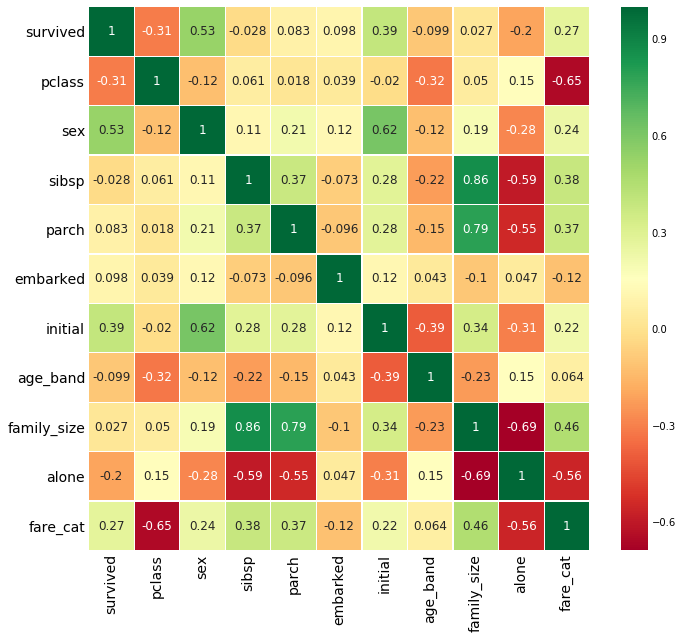

In [54]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':12})
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Modeling

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

y = data['survived'].values
X = data.drop(['survived'], axis = 1).values

## Support Vector Classifier

Best parameters set found on development set:

{'C': 0.7, 'gamma': 0.1, 'kernel': 'rbf'}
Detailed classification report:

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       405
          1       0.77      0.71      0.74       250

avg / total       0.81      0.81      0.81       655


[[353  52]
 [ 72 178]]


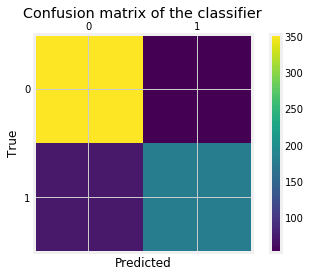

In [78]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
tuned_parameters={'kernel':kernel,'C':C,'gamma':gamma}

clf = GridSearchCV(SVC(), tuned_parameters, cv=5)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
labels = [0, 1]

print("Best parameters set found on development set:")
print()
print(clf.best_params_)  
print("Detailed classification report:")
print()
print(classification_report(y_true, y_pred))
print()

labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Logistic Regreesion Classifier

In [ ]:
model3 = LogisticRegression()
model3.fit(train_X,train_Y)
prediction3=model3.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

## Question 2

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Using PyMC3, use a Gaussian process to fit a non-parametric regression model to this data, choosing an appropriate covariance function. Plot 10 regression lines drawn from your process.

In [2]:
%matplotlib inline
from sklearn.datasets import load_diabetes
import pandas as pd

daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)



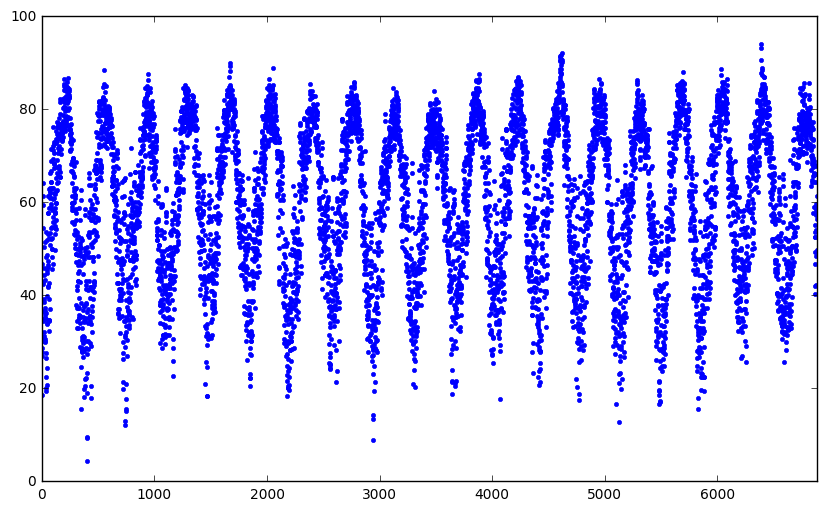

In [3]:
daily_temps.temp.plot(style='b.', figsize=(10,6), grid=False)

In [4]:
# Write your answer here

## Question 3

Fit a series of random-forest classifiers to the Wisconsin breast cancer dataset (`wisconsin_breast_cancer.csv`), to explore the sensitivity to the parameters `max_features`, the number of variables considered for splitting at each step, `max_depth`, the maximum depth of the tree, and `n_estimators`, the number of trees in the forest. Use apprpriate metrics of performance, and include plots against a suitably-chosen range of values for these parameters.

Dataset description: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus:

- `radius` (mean of distances from center to points on the perimeter) 
- `texture` (standard deviation of gray-scale values) 
- `perimeter` 
- `area` 
- `smoothness` (local variation in radius lengths) 
- `compactness` (perimeter^2 / area - 1.0) 
- `concavity` (severity of concave portions of the contour) 
- `concave points` (number of concave portions of the contour) 
- `symmetry` 
- `fractal dimension` ("coastline approximation" - 1)

The outcome to be predicted is tumor type (M = malignant, B = benign).

In [6]:
# Write your work here

## Question 4

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the Wisconsin breast cancer data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

In [7]:
# Write your work here